In [3]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

### ✅ Phase 2 – Step 3: Build and Train Your U-Net Model

In [6]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))

        bottleneck = self.bottleneck(self.pool3(enc3))

        dec3 = self.upconv3(bottleneck)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.final(dec1))


In [7]:
device = torch.device('cpu')  # or 'cuda' if working
model = UNet().to(device)
print("✅ Model created and moved to:", device)


✅ Model created and moved to: cpu


In [8]:
import torch

device = torch.device('cpu')  # ✅ Safe: always works
print("Using device:", device)


Using device: cpu


In [9]:
epochs = 2  # max 3–5 for now
batch_size = 1
image_size = 128


In [11]:
import torch.nn as nn

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 🔁 Train the model (very light version)
epochs = 2  # You can increase later
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/2, Loss: 179.9808
Epoch 2/2, Loss: 131.6163


In [27]:
torch.save(model.state_dict(), 'unet_rock_model.pth')
print("✅ Model saved as unet_rock_model.pth")


✅ Model saved as unet_rock_model.pth


### ✅ Phase 2 – Step 4: Use Your Trained Model to Predict on New Rock CT Images

In [43]:
model = UNet().to(device)
model.load_state_dict(torch.load('unet_rock_model.pth', map_location=device))
model.eval()  # set to evaluation mode
print("✅ Model loaded and ready for prediction")


✅ Model loaded and ready for prediction


In [45]:
import cv2
import numpy as np

# Load image
img_path = 'augmented/slice_0_aug_0.png'  # You can change this to any image from your dataset
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))
img = img / 255.0  # normalize to 0–1

# Convert to torch tensor
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


In [47]:
with torch.no_grad():
    pred_mask = model(img_tensor).squeeze().cpu().numpy()


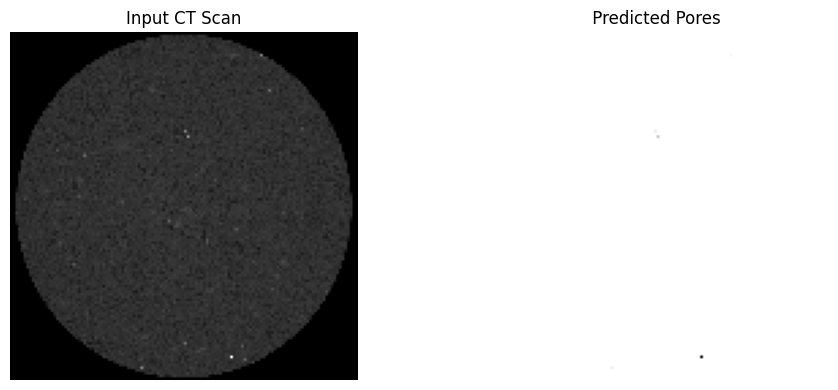

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Input CT Scan")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title(" Predicted Pores")
plt.axis('off')

plt.tight_layout()
plt.show()


### ✅ Phase 3 – Test on Real Rock CT Images

In [60]:
# Load model from saved file
model = UNet().to(device)  # Use CPU or GPU depending on earlier setting
model.load_state_dict(torch.load('unet_rock_model.pth', map_location=device))
model.eval()  # Set model to evaluation mode (disables dropout, etc.)
print("✅ Model loaded and ready for prediction")


✅ Model loaded and ready for prediction


In [95]:
import cv2
import numpy as np

# Load a grayscale CT image (user's input)
img_path = "user_inputs/slice_0_aug_0.png"  # 👈 replace with the actual user image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Resize to match your model input shape
img = cv2.resize(img, (128, 128))

# Normalize pixel values to 0–1 (model was trained on normalized images)
img = img / 255.0

# Convert to tensor and reshape to match (1, 1, H, W)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


In [97]:
with torch.no_grad():  # Disable gradient tracking for speed
    pred_mask = model(img_tensor).squeeze().cpu().numpy()


In [ ]:
🧠 What it does:

Feeds the image into the U-Net
Gets a predicted probability map of pore regions
Converts it back to a 2D NumPy array for display

In [ ]:
✅ Step 3.4: Show Input CT vs Predicted Pore Mask

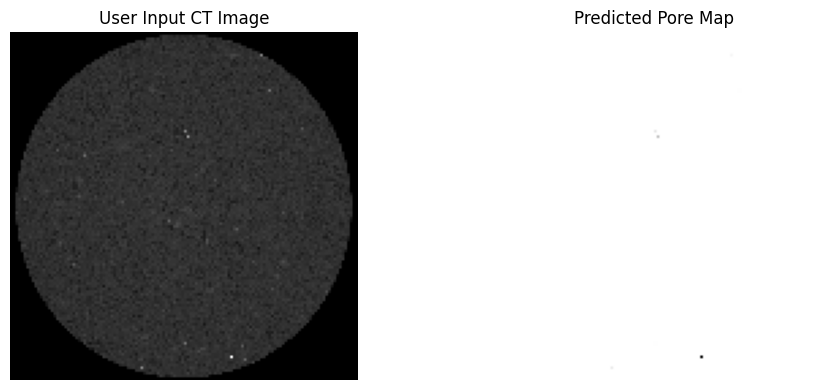

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Original CT scan
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("User Input CT Image")
plt.axis('off')

# Predicted mask from model
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Pore Map")
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
✅ Step 3.5: Estimate Porosity from Prediction

In [101]:
# Convert soft prediction to binary mask using threshold
binary_mask = (pred_mask > 0.5).astype(np.uint8)

# Count how many pixels are pores
total_pixels = binary_mask.size
pore_pixels = np.sum(binary_mask)

# Calculate porosity percentage
porosity_percent = (pore_pixels / total_pixels) * 100
print(f"📊 Estimated Porosity: {porosity_percent:.2f}%")


📊 Estimated Porosity: 99.99%


### phae 3 over all code output will be :

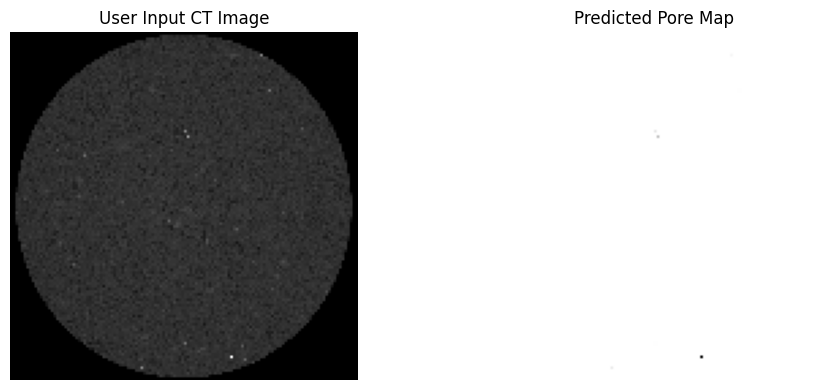

📊 Estimated Porosity: 99.99%


In [103]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

# Path to test image
img_path = "user_inputs/slice_0_aug_0.png"  # or whatever file you uploaded


# Check if image exists
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found at: {img_path}")

# Read and process the image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("cv2.imread failed — image may be corrupted or unreadable")

img = cv2.resize(img, (128, 128)) # Resize to match your model input shape

img = img / 255.0 # Normalize pixel values to 0–1 (model was trained on normalized images)

# Convert to tensor and reshape to match (1, 1, H, W)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device) 

# Run model prediction
with torch.no_grad():
    pred_mask = model(img_tensor).squeeze().cpu().numpy()

# Show original + prediction
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title("User Input CT Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.title("Predicted Pore Map")
plt.axis('off')

plt.tight_layout()
plt.show()

# Porosity estimation
binary_mask = (pred_mask > 0.5).astype(np.uint8)
porosity_percent = (np.sum(binary_mask) / binary_mask.size) * 100
print(f"📊 Estimated Porosity: {porosity_percent:.2f}%")

### ✅ Phase 4 – Make Your Rock Property Prediction Project Usable by Others